# Implement U-net for Watermark Removal

In [1]:
import random
import warnings
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader

# set constants
SEED = 42
EPOCHS = 1
BATCH_SIZE = 32
EPSILON = 1e-4
LEARNING_RATE = 1e-4
BETA_VALUES = (0.9, 0.95)
DECAY_AFTER_ITERATIONS = 200000
DECAY_FACTOR = 0.5

# make the code deterministic
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# set a few settings
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
sns.set_style("darkgrid")
warnings.filterwarnings("ignore")

Using device: cuda


## Define the architecture

In [2]:
class UNet(nn.Module):
    KERNEL_SIZE_CONV = 3
    KERNEL_SIZE_CONVT = 2
    STRIDE_CONVT = 2
    KERNEL_SIZE_MAX_POOLING = 2
    PADDING = "same"

    def __init__(self, unet_channels_in, unet_channels_out):
        super(UNet, self).__init__()

        # encoder
        self.conv_relu_1 = self.conv_relu(unet_channels_in, 48)
        self.conv_relu_pooling_2 = self.conv_relu_pooling(48, 48)
        self.conv_relu_pooling_3 = self.conv_relu_pooling(48, 48)
        self.conv_relu_pooling_4 = self.conv_relu_pooling(48, 48)
        self.conv_relu_pooling_5 = self.conv_relu_pooling(48, 48)
        self.conv_relu_pooling_6 = self.conv_relu_pooling(48, 48)

        # bottleneck
        self.conv_relu_pooling_7 = self.conv_relu_pooling(48, 48)

        # decoder
        self.conv_relu_convt8 = self.conv_relu_convt(96, 96)
        self.conv_relu_9 = self.conv_relu(96, 96)
        self.conv_relu_convt10 = self.conv_relu_convt(144, 96)
        self.conv_relu11 = self.conv_relu(96, 96) # the dimensions are not mentioned in the paper
        self.conv_relu_convt12 = self.conv_relu_convt(144, 96)
        self.conv_relu13 = self.conv_relu(96, 96)
        self.conv_relu_convt14 = self.conv_relu_convt(144, 96)
        self.conv_relu15 = self.conv_relu(96, 96)
        self.conv_relu_convt16 = self.conv_relu_convt(144, 96)
        self.conv_relu17 = self.conv_relu(96, 96)
        self.conv_relu_convt18 = self.conv_relu_convt(99, 96)
        self.conv_relu19 = self.conv_relu(96, 64)
        self.conv_relu20 = self.conv_relu(64, 32)
        self.conv_leaky_relu21 = self.conv_leaky_relu(32, unet_channels_out)

    def conv_relu(self, channels_in, channels_out):
        return nn.Sequential(
            nn.Conv2d(
                channels_in,
                channels_out,
                kernel_size=UNet.KERNEL_SIZE_CONV,
                padding=UNet.PADDING
            ),
            nn.ReLU(inplace=True),
        )

    def conv_leaky_relu(self, channels_in, channels_out):
        return nn.Sequential(
            nn.Conv2d(
                channels_in,
                channels_out,
                kernel_size=UNet.KERNEL_SIZE_CONV,
                padding=UNet.PADDING
            ),
            nn.LeakyReLU(inplace=True),
        )

    def conv_relu_pooling(self, channels_in, channels_out):
        return nn.Sequential(
            nn.Conv2d(
                channels_in,
                channels_out,
                kernel_size=UNet.KERNEL_SIZE_CONV,
                padding=UNet.PADDING
            ),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(UNet.KERNEL_SIZE_MAX_POOLING),
        )

    def conv_relu_convt(self, channels_in, channels_out):
        return nn.Sequential(
            nn.Conv2d(
                channels_in,
                channels_out,
                kernel_size=UNet.KERNEL_SIZE_CONV,
                padding=UNet.PADDING
            ),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(
                channels_out,
                channels_out,
                kernel_size=UNet.KERNEL_SIZE_CONVT,
                stride=UNet.STRIDE_CONVT
            ),
        )

    def forward(self, x):
        # encoder
        enc1 = self.conv_relu_1(x)
        enc2 = self.conv_relu_pooling_2(enc1)
        enc3 = self.conv_relu_pooling_3(enc2)
        enc4 = self.conv_relu_pooling_4(enc3)
        enc5 = self.conv_relu_pooling_5(enc4)
        enc6 = self.conv_relu_pooling_6(enc5)

        # bottleneck
        bottleneck7 = self.conv_relu_pooling_7(enc6)

        # decoder
        decoder8 = self.conv_relu_convt8(
            torch.cat(
                [
                    bottleneck7,
                    F.interpolate(
                        enc6,
                        bottleneck7.size()[2:],
                        mode="bilinear",
                        align_corners=True,
                    ),
                ],
                dim=1,
            )
        )
        decoder9 = self.conv_relu_9(decoder8)
        decoder10 = self.conv_relu_convt10(
            torch.cat(
                [
                    decoder9,
                    F.interpolate(
                        enc5, decoder9.size()[2:], mode="bilinear", align_corners=True
                    ),
                ],
                dim=1,
            )
        )
        decoder11 = self.conv_relu11(decoder10)
        decoder12 = self.conv_relu_convt12(
            torch.cat(
                [
                    decoder11,
                    F.interpolate(
                        enc4, decoder11.size()[2:], mode="bilinear", align_corners=True
                    ),
                ],
                dim=1,
            )
        )
        decoder13 = self.conv_relu13(decoder12)
        decoder14 = self.conv_relu_convt14(
            torch.cat(
                [
                    decoder13,
                    F.interpolate(
                        enc3, decoder13.size()[2:], mode="bilinear", align_corners=True
                    ),
                ],
                dim=1,
            )
        )
        decoder15 = self.conv_relu15(decoder14)
        decoder16 = self.conv_relu_convt16(
            torch.cat(
                [
                    decoder15,
                    F.interpolate(
                        enc2, decoder15.size()[2:], mode="bilinear", align_corners=True
                    ),
                ],
                dim=1,
            )
        )
        decoder17 = self.conv_relu17(decoder16)
        decoder18 = self.conv_relu_convt18(
            torch.cat(
                [
                    decoder17,
                    F.interpolate(
                        x, decoder17.size()[2:], mode="bilinear", align_corners=True
                    ),
                ],
                dim=1,
            )
        )
        decoder19 = self.conv_relu19(decoder18)
        decoder20 = self.conv_relu20(decoder19)

        return self.conv_leaky_relu21(decoder20)


## Load images

In [3]:
class OxfordPetDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image = Image.open(row["image_path"])
        label = int(row["class"]) - 1  # Subtract 1 to make classes zero-indexed

        if self.transform:
            image = self.transform(image)

        return image, label


transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)


### Load images without watermarks

In [4]:
trainval_data_wo_watermark = (
    pd.read_csv("./data/pet_dataset_info.csv")
    .query("fold == 'trainval'")
    .sample(frac=1, random_state=SEED)
    .reset_index(drop=True)
)
test_data_wo_watermark = (
    pd.read_csv("./data/pet_dataset_info.csv")
    .query("fold == 'test'")
    .sample(frac=1, random_state=SEED)
    .reset_index(drop=True)
)

train_loader_wo_watermark = DataLoader(
    OxfordPetDataset(trainval_data_wo_watermark, transform=transform),
    batch_size=BATCH_SIZE,
    shuffle=False,
)
test_loader_wo_watermark = DataLoader(
    OxfordPetDataset(test_data_wo_watermark, transform=transform),
    batch_size=BATCH_SIZE,
    shuffle=False,
)


### Load images with watermarks

In [5]:
trainval_data_w_watermark = trainval_data_wo_watermark.copy(deep=True)
test_data_w_watermark = test_data_wo_watermark.copy(deep=True)

trainval_data_w_watermark["image_path"] = trainval_data_w_watermark["image_path"].map(
    lambda x: x.replace("resized_images", "images_with_logos")
)
test_data_w_watermark["image_path"] = test_data_w_watermark["image_path"].map(
    lambda x: x.replace("resized_images", "images_with_logos")
)

train_loader_w_watermark = DataLoader(
    OxfordPetDataset(trainval_data_w_watermark, transform=transform), batch_size=BATCH_SIZE, shuffle=False
)
test_loader_w_watermark = DataLoader(
    OxfordPetDataset(test_data_w_watermark, transform=transform), batch_size=BATCH_SIZE, shuffle=False
)


## Train and test the network

### Define the loss, tranin and test functions

In [6]:
class LADLoss(nn.Module):
    def __init__(self):
        super(LADLoss, self).__init__()

    def forward(self, predictions, targets):
        return torch.mean(torch.abs(predictions - targets))

In [7]:
def train_watermark_removal_network(unet, train_loader_w_watermark, train_loader_wo_watermark, loss_fn):
    unet.train()

    with tqdm(total=len(train_loader_w_watermark)) as pbar:
        for (x_w_watermark, _), (x_wo_watermark, _) in zip(train_loader_w_watermark, train_loader_wo_watermark):
            pred = unet(x_w_watermark.to(DEVICE))

            loss = loss_fn(pred, x_wo_watermark.to(DEVICE))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss = loss.item()
            scheduler.step()
            pbar.update(1)

        print(f"train loss: {train_loss} ", end="")
        torch.save(unet.state_dict(), "./models/watermark_removal.pth")

    return train_loss


In [8]:
def test_watermark_removal_network(unet, test_loader_w_watermark, test_loader_wo_watermark, loss_fn):
    unet.eval()

    test_loss = 0
    num_batches = len(test_loader_w_watermark)

    with tqdm(total=len(test_loader_w_watermark)) as pbar:
        with torch.no_grad():
            for (x_w_watermark, _), (x_wo_watermark, _) in zip(test_loader_w_watermark, test_loader_wo_watermark):
                pred = unet(x_w_watermark.to(DEVICE))
                test_loss += loss_fn(pred, x_wo_watermark.to(DEVICE)).item()
                pbar.update(1)

    print(f"test loss: {test_loss / num_batches}\n")

    return test_loss / num_batches


### Run the training and testing
After each epoch the model together with the loss are stored

In [9]:
unet = UNet(3, 3).to(DEVICE)
total_params = sum(layer.numel() for layer in unet.parameters())
print(f"The model has {total_params} parameters")

loss_fn = LADLoss()
optimizer = torch.optim.Adam(unet.parameters(), lr=LEARNING_RATE, betas=BETA_VALUES, eps=EPSILON)
scheduler = StepLR(optimizer, step_size=DECAY_AFTER_ITERATIONS // BATCH_SIZE, gamma=DECAY_FACTOR)

train_loss_values = []
test_loss_values = []

for epoch in range(EPOCHS):
    print(f"epoch {epoch + 1} / {EPOCHS}", end="")
    train_loss = train_watermark_removal_network(unet, train_loader_w_watermark, train_loader_wo_watermark, loss_fn)
    test_loss = test_watermark_removal_network(unet, test_loader_w_watermark, test_loader_wo_watermark, loss_fn)

    train_loss_values.append(train_loss)
    test_loss_values.append(test_loss)

    loss_values = pd.DataFrame(
        {"epoch": list(range(len(train_loss_values))), "train loss": train_loss_values, "test loss": test_loss_values}
    )
    loss_values.to_csv("./resources/watermark_removal_loss_evolution.csv", index=None)


The model has 1504419 parameters
epoch 1 / 1

100%|██████████| 115/115 [02:04<00:00,  1.09s/it]


train loss: 0.650800347328186 

100%|██████████| 115/115 [01:01<00:00,  1.88it/s]

test loss: 0.6640185604924741



### Display and store the loss evolution

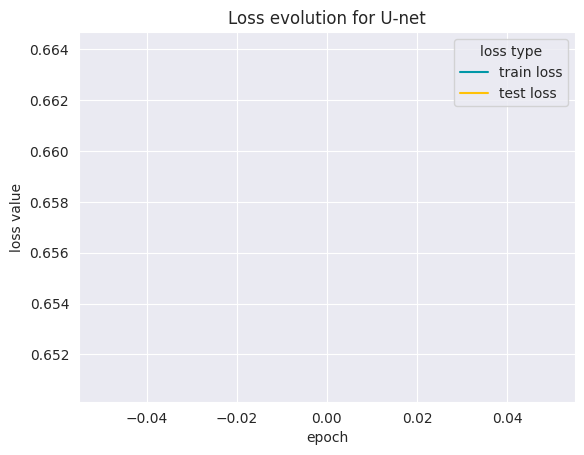

In [10]:
loss_values = (
    loss_values[["train loss", "test loss"]].melt().rename({"variable": "loss type", "value": "loss value"}, axis=1)
)
loss_values["epoch"] = 2 * list(range(loss_values.shape[0] // 2))

sns.lineplot(data=loss_values, x="epoch", y="loss value", hue="loss type", palette=["#0097A7", "#FFC107"])
plt.title("Loss evolution for U-net")
plt.savefig("./resources/loss_evolution_watermark_removal.png", dpi=200)
plt.show()


## Infer using the network
To use the network you need first to run the cells corresponding to imports, architecture definition and data loading

In [11]:
def inverse_normalize(tensor):
    # the images fed to the network have normalized pixels and this function applies the inverse operation so that the values are between 0 and 255
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    mean = torch.tensor(mean).reshape(1, 3, 1, 1)
    std = torch.tensor(std).reshape(1, 3, 1, 1)
    tensor = tensor * std + mean

    return tensor

In [12]:
plt.style.use("default")

# load the network
loaded_unet = UNet(3, 3)
loaded_unet.load_state_dict(torch.load("./models/watermark_removal.pth"))
loaded_unet.eval()
loaded_unet = loaded_unet.to(DEVICE)

# store in the lists below all the images from the test set as numpy arrays
images_with_watermark = []
images_cleaned = []
images_without_watermark = []

# removes the watermark from each test image and converts each image to a numpy array with values between 0 and 255
with torch.no_grad():
    for (x_w_watermark, _), (x_wo_watermark, _) in zip(test_loader_w_watermark, test_loader_wo_watermark):
        predicted_clean_images = loaded_unet(x_w_watermark.to(DEVICE))

        for image_with_watermark in x_w_watermark:
            images_with_watermark.append(
                np.transpose(inverse_normalize(image_with_watermark).cpu().numpy()[0], (1, 2, 0))
            )
        for image_without_watermark in x_wo_watermark:
            images_without_watermark.append(
                np.transpose(inverse_normalize(image_without_watermark).cpu().numpy()[0], (1, 2, 0))
            )
        for clean_image in predicted_clean_images:
            images_cleaned.append(np.transpose(inverse_normalize(clean_image.to("cpu")).cpu().numpy()[0], (1, 2, 0)))


### Display and store a set of image triplets (with watermark, cleaned, without watermark)

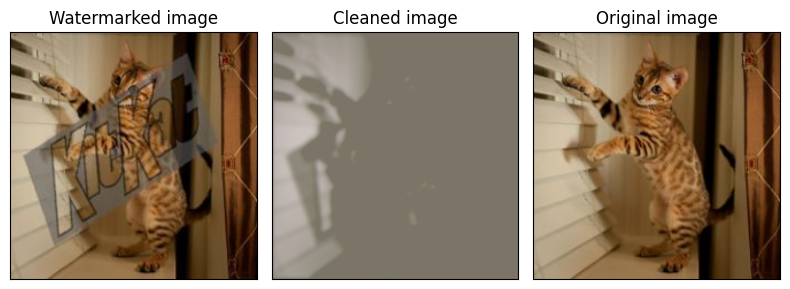

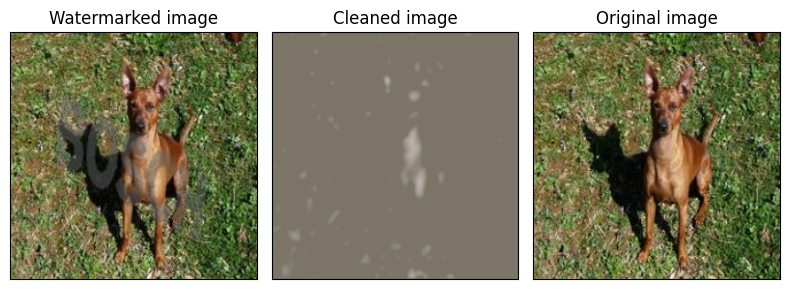

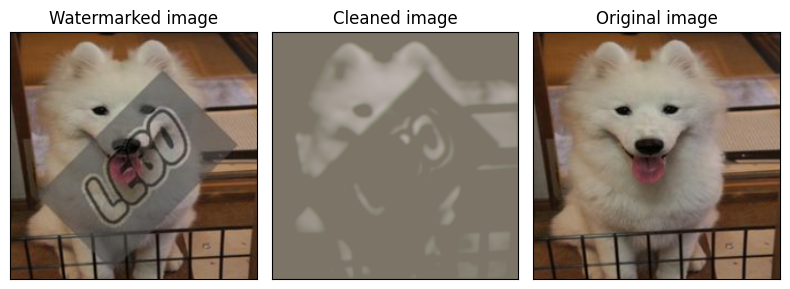

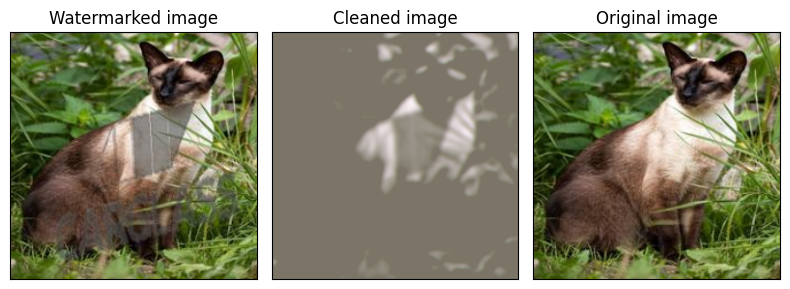

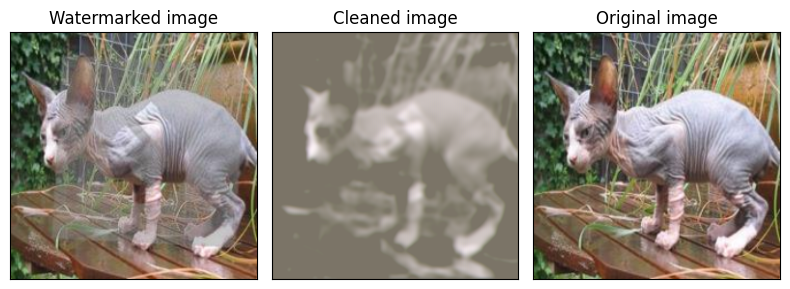

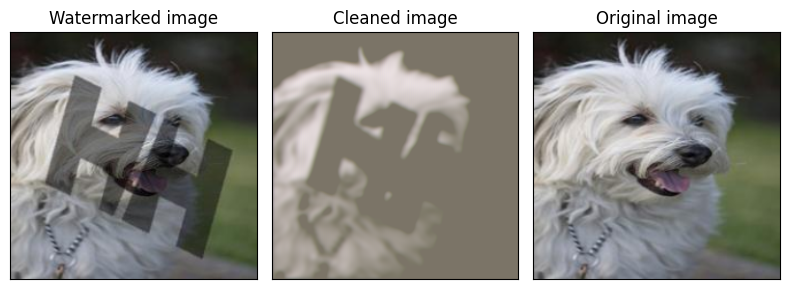

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


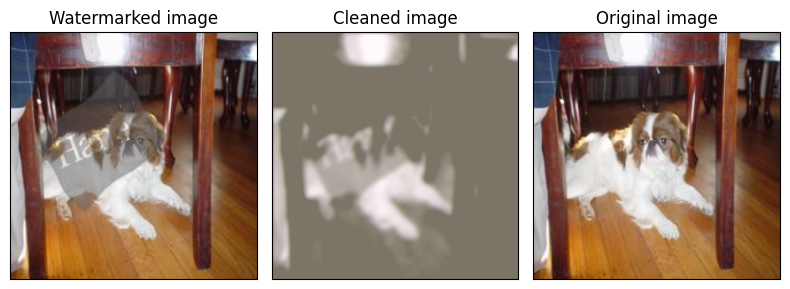

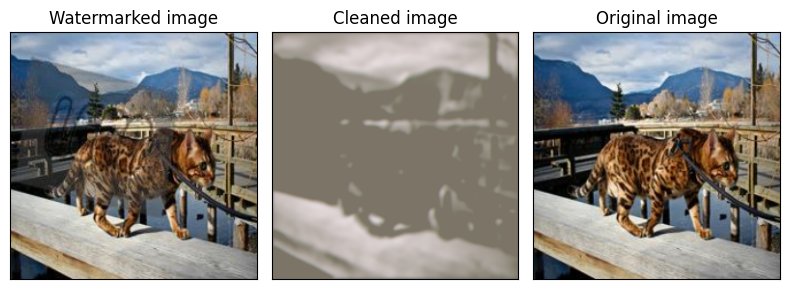

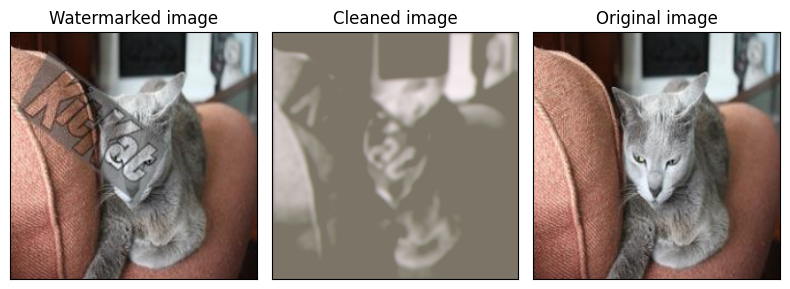

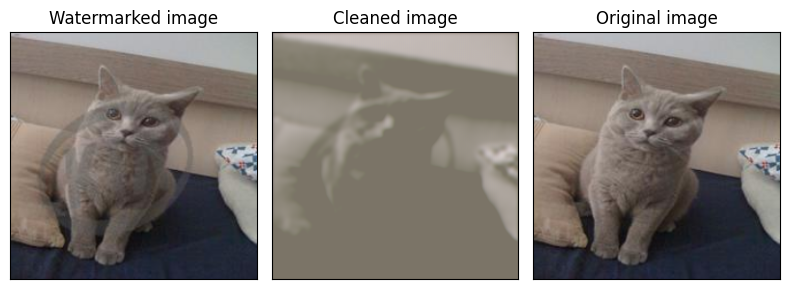

In [13]:
show_images_no = 10

for image_index in range(show_images_no):
    fig, axes = plt.subplots(1, 3, figsize=(8, 12))
    axes[0].imshow(images_with_watermark[image_index])
    axes[0].set_title("Watermarked image")
    axes[1].imshow(images_cleaned[image_index])
    axes[1].set_title("Cleaned image")
    axes[2].imshow(images_without_watermark[image_index])
    axes[2].set_title("Original image")

    for i in range(3):
        axes[i].set_xticks([])
        axes[i].set_yticks([])
    plt.tight_layout()

    plt.savefig(
        f"./resources/watermark_removal_sample_{image_index}.png", dpi=200, bbox_inches="tight"
    )
    plt.show()


### Store all test images with watermarks removed

In [14]:
cleaned_images_paths = (
    test_data_w_watermark["image_path"].map(lambda x: x.replace("images_with_logos", "images_cleaned")).to_list()
)

for image_index in range(len(cleaned_images_paths)):
    cleaned_to_store = Image.fromarray((images_cleaned[image_index] * 255).astype(np.uint8)).resize((224, 224))
    cleaned_to_store.save(cleaned_images_paths[image_index])
